In [4]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [5]:
#### Preprocecing ###

In [6]:
jh_dir = "../../COVID-19"

In [7]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [8]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [9]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [10]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [11]:
### Data Preparation ###

In [12]:
country = 'Italy'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-26')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 6036_0000
iteration=2000
repeat = 1000

In [13]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [14]:
### Model ###

In [15]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f472b1d2ccdff3099b75bd7cdafce0c4 NOW.


In [16]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a5549457d9a2746de59f880209cc026 NOW.


In [17]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f472b1d2ccdff3099b75bd7cdafce0c4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   422.18   44.68  64.96 356.04 379.25 392.79 451.56 553.52      2   4.26
b            0.46    0.03   0.58   0.03   0.11   0.26   0.57   2.25    417    1.0
p            0.31    0.02   0.24   0.03   0.11   0.23   0.46   0.87    227   1.01
q             1.0  2.5e-6 6.0e-5    1.0    1.0    1.0    1.0    1.0    587   1.01
NI[1]       55.72    3.21   6.85  44.05  50.96  55.09  59.86   71.6      5   1.37
NI[2]       61.24     4.1   7.82  48.55  55.54  59.87  66.49  78.14      4   1.53
NI[3]       65.35    3.91   7.81   52.5  59.77   64.3  70.08  82.61      4   1.44
NI[4]       71.82    4.74   8.66  57.76  65.58  70.28  77.26  89.96      3   1.59
NI[5]       76.99     4.1   8.76 

In [18]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits, control={'adapt_delta':0.99999})
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7a5549457d9a2746de59f880209cc026.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.62    0.07   1.01    0.3   0.87    1.4   2.15    4.2    188   1.02
b_beta      1.0  2.5e-3   0.05   0.91   0.97    1.0   1.03   1.11    360   1.02
b[1]       1.67    0.05   1.15   0.22   0.83   1.41   2.24   4.65    558   1.01
b[2]       2.14    0.09   1.59   0.18   0.95   1.78   2.93   6.09    333   1.02
b[3]       2.48    0.12   1.91   0.17   1.06   2.05   3.37   7.24    264   1.02
b[4]       2.81    0.15   2.17   0.25   1.17    2.3   3.87   8.23    221   1.02
b[5]       3.14    0.17   2.26   0.22   1.45    2.7   4.35   8.89    185   1.02
b[6]       3.55    0.16   2.34   0.38   1.85   3.08   4.75   9.38    211   1.02
b[7]       3.59    0.17   2.36   0.49   1.89   3.08

In [19]:
print(fit_every)

Inference for Stan model: anon_model_7a5549457d9a2746de59f880209cc026.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.62    0.07   1.01    0.3   0.87    1.4   2.15    4.2    188   1.02
b_beta         1.0  2.5e-3   0.05   0.91   0.97    1.0   1.03   1.11    360   1.02
b[1]          1.67    0.05   1.15   0.22   0.83   1.41   2.24   4.65    558   1.01
b[2]          2.14    0.09   1.59   0.18   0.95   1.78   2.93   6.09    333   1.02
b[3]          2.48    0.12   1.91   0.17   1.06   2.05   3.37   7.24    264   1.02
b[4]          2.81    0.15   2.17   0.25   1.17    2.3   3.87   8.23    221   1.02
b[5]          3.14    0.17   2.26   0.22   1.45    2.7   4.35   8.89    185   1.02
b[6]          3.55    0.16   2.34   0.38   1.85   3.08   4.75   9.38    211   1.02
b[7]          3.59    0.17   2.36   0.49   1.89   3.08   4.74   

In [20]:
# Save models

In [21]:
## Saving results

In [26]:
import pickle
with open("sm_const_fit-Italy.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
import pickle
with open("sm_every_fit-Italy.pkl", "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
### Load modesl

In [25]:
with open("sm_const_fit-Italy.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

FileNotFoundError: [Errno 2] No such file or directory: 'sm_const_fit-Italy.pkl'

In [ ]:
with open("sm_every_fit-Italy.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [43]:
### Convergence

In [44]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee5acf4810>,
      dtype=object)

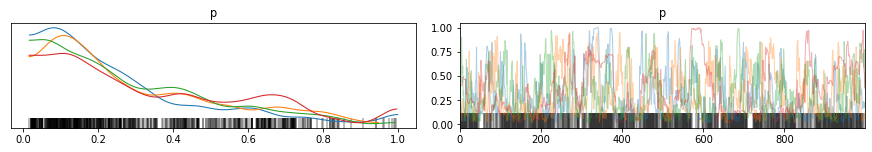

In [45]:
az.plot_trace(data_const, var_names=['p'])

In [ ]:
### model selection

In [29]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 4000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo 36836.83  4215.60
p_loo   5971.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          2    2.4%
   (0.7, 1]   (bad)         3    3.6%
   (1, Inf)   (very bad)   79   94.0%

In [30]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 84 log-likelihood matrix

       Estimate       SE
IC_loo   784.00    41.54
p_loo     61.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       16   19.0%
 (0.5, 0.7]   (ok)          2    2.4%
   (0.7, 1]   (bad)        58   69.0%
   (1, Inf)   (very bad)    8    9.5%

In [31]:
az.compare({'const':data_const, 'everyday':data_every})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,741.02,40.0673,0,1,9871.26,0,True,deviance
const,1,70961.6,23034.3,70220.6,0,39.5808,10093.8,True,deviance


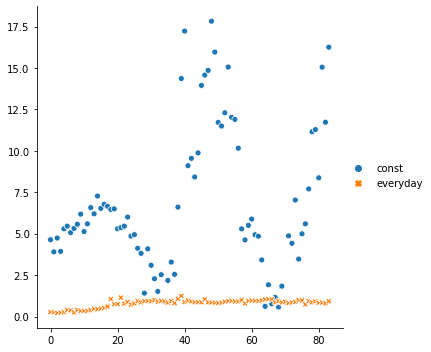

In [32]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k})
sns.relplot(data=df)

In [33]:
df.idxmax()

const       48
everyday    39
dtype: int64

In [ ]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [ ]:
### Visualization ###

In [36]:
def extract(data):
    index=pd.date_range(start=epoch, end=last-pd.Timedelta(days=2))
    init_inf = pd.DataFrame(data_every.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
    b = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
    q = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
    NI = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
    a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
    d = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    p = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    C = NI.cumsum().shift(periods=1)
    NI0 = q*NI
    C0 = NI0.cumsum().shift(periods=1)

    return a, d, p, b, q, NI, NI0, C, C0

In [37]:
a_e, d_e, p_e, b_e, q_e, NI_e, NI0_e, C_e, C0_e = extract(data_every)

In [38]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


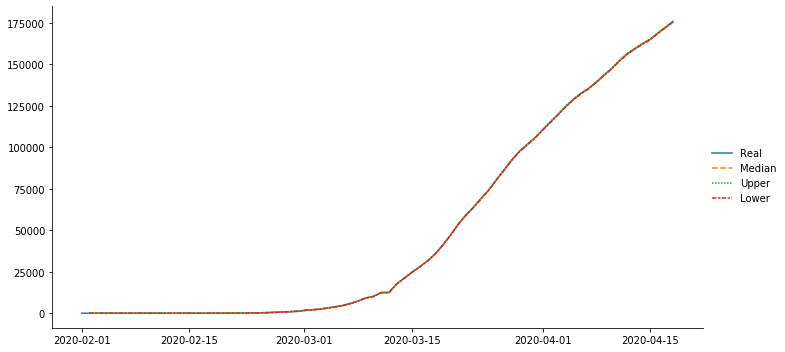

In [39]:
draw(C0_e, real=confirmed[country])

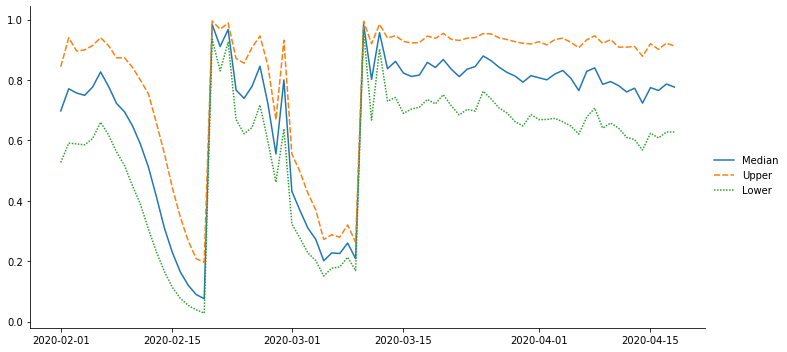

In [40]:
draw(q_e)

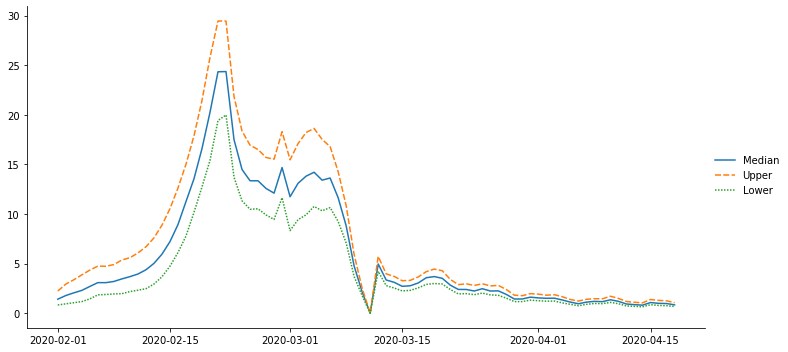

In [41]:
draw(b_e)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


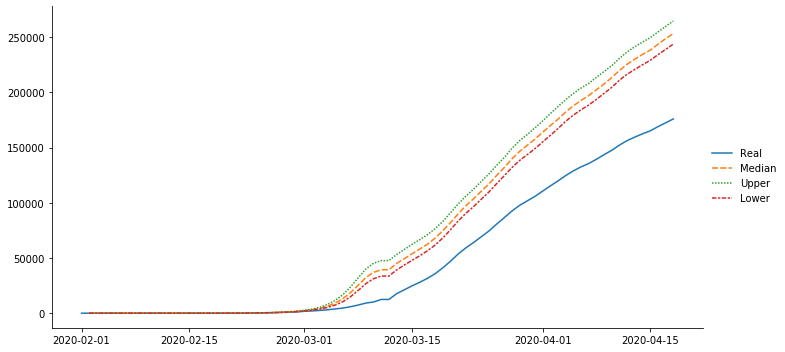

In [42]:
draw(C_e, real=confirmed[country])

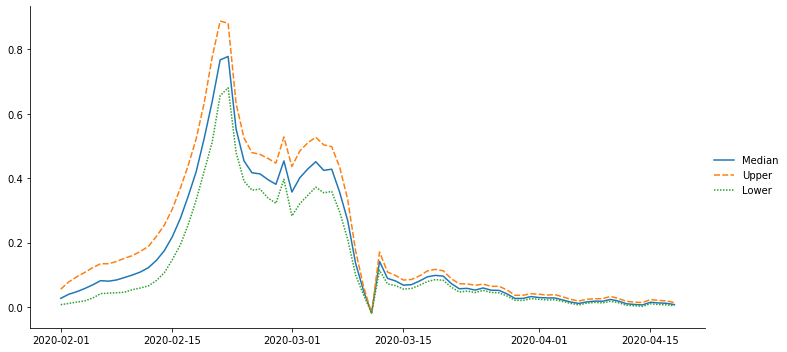

In [47]:
a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
p = pd.DataFrame(data_every.posterior['p'].stack(sample=('chain', 'draw')).values)
beta = pd.DataFrame(np.array([b_e[i].values * -np.log(1 - p.iloc[i].values) - a.iloc[i].values for i in range(len(p))]).T, index=b_e.index)
draw(beta)